In [80]:
import tensorflow as tf
from datetime import datetime

print(tf.__version__)
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

2.9.2
Num of GPUs available:  13


2022-07-04 12:03:00.652917: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-04 12:03:00.652942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [82]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

In [83]:
# download dataset
# Path
dataset_path = "./dataset/monkeys/"
ipfs_monkey_uri="https://calibration-ipfs.filswan.com/ipfs/QmQhckZqk2rPyeyekt6KMTAR4TEKAs1xi8R3DTCgFqfQgs"
isdir = os.path.isdir(dataset_path)
if isdir:
  print("Dataset Monkey found.")


Dataset Monkey found.


In [84]:
# load training and testing sets
train_dataset_path = dataset_path + "training/training/"
test_dataset_path = dataset_path + "validation/validation/"
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train = datagen.flow_from_directory(train_dataset_path, target_size=(160, 160), batch_size=32)
test = datagen.flow_from_directory(test_dataset_path, target_size=(160, 160), batch_size=32, shuffle=False)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [85]:
# read labels
file = pd.read_csv(dataset_path +'monkey_labels.txt', sep='[\s,]{2,20}', engine='python')
labels = file['Common Name']
labels

0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object

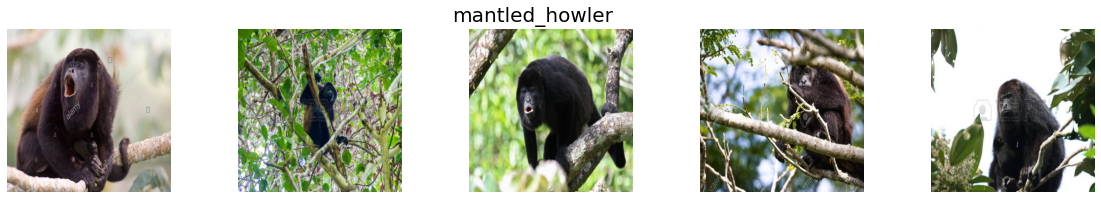

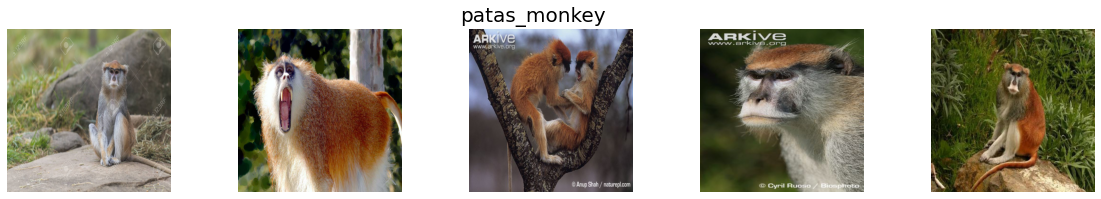

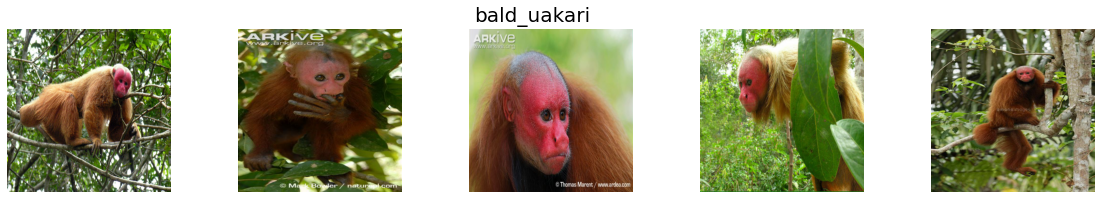

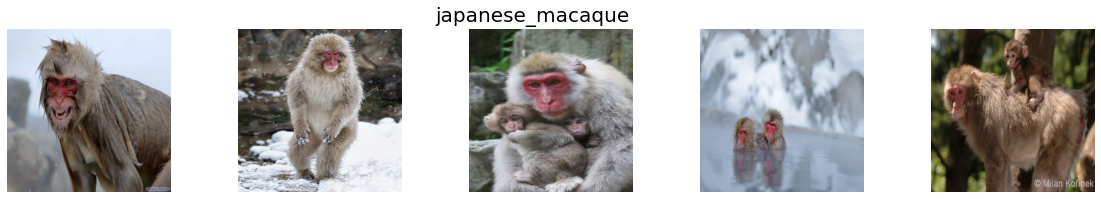

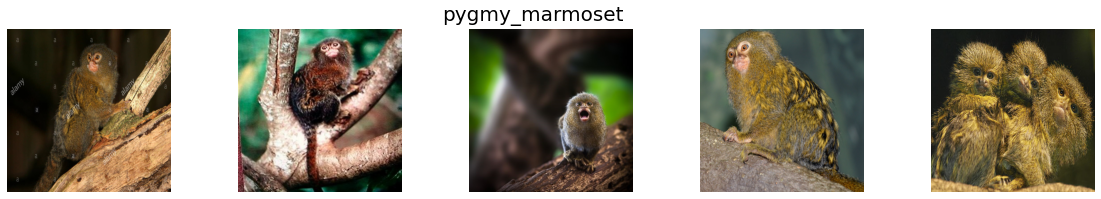

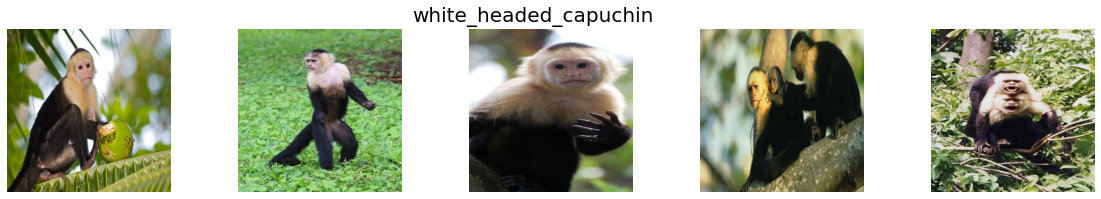

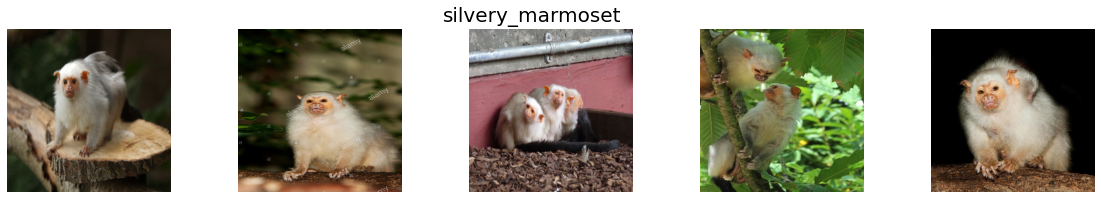

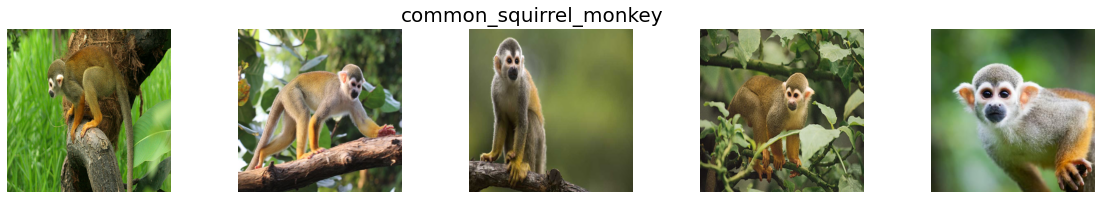

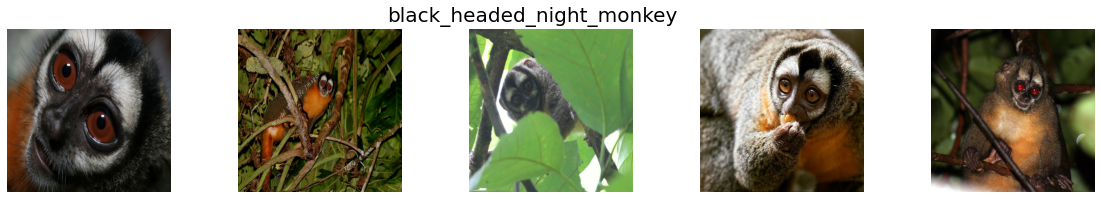

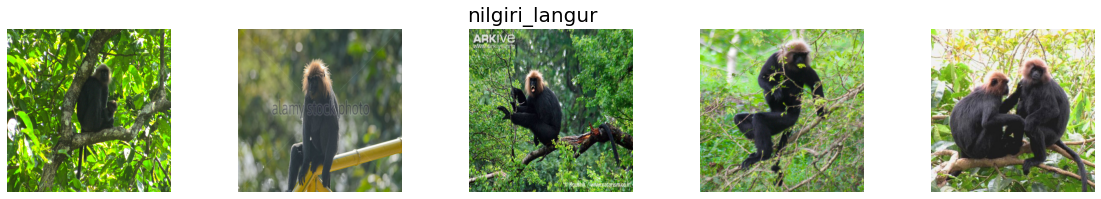

In [86]:
# display images of each category
folders = os.listdir(train_dataset_path)
folders.sort()
for i, folder in enumerate(folders):
    path = train_dataset_path + folder
    imgs = os.listdir(path)
    plt.figure(figsize=(20, 3))
    for j in range(5):
        img = cv2.cvtColor(cv2.imread(path + '/' + imgs[j]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (640, 640))
        plt.subplot(1, 5, j + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(labels[i], fontsize="20")
    plt.show()
    print("\n\n")

In [87]:
IMG_SHAPE = (160, 160, 3)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

In [88]:
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(514, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_16 (Dense)            (None, 514)               526850    
                                                           

In [89]:
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/Users/ccao/miniforge3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [90]:
history = model.fit(train, epochs=5)

Epoch 1/5


2022-07-04 12:03:06.278149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 14s 333ms/step - loss: 1.0337 - accuracy: 0.6985
Epoch 2/5
35/35 [==============================] - 12s 333ms/step - loss: 0.1655 - accuracy: 0.9617
Epoch 3/5
35/35 [==============================] - 12s 340ms/step - loss: 0.0781 - accuracy: 0.9872
Epoch 4/5
35/35 [==============================] - 12s 344ms/step - loss: 0.0383 - accuracy: 0.9991
Epoch 5/5
35/35 [==============================] - 12s 346ms/step - loss: 0.0259 - accuracy: 0.9991


{'loss': [1.0337424278259277, 0.16551855206489563, 0.0781165137887001, 0.03826185688376427, 0.025873543694615364], 'accuracy': [0.6985427737236023, 0.9617486000061035, 0.9872495532035828, 0.999089241027832, 0.999089241027832]}


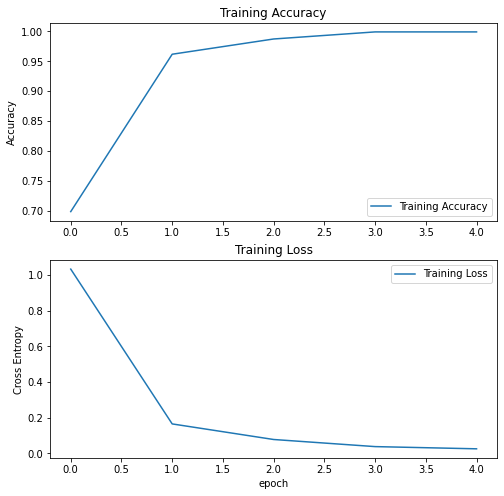

In [91]:
print(history.history)
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [92]:
prediction = model.predict_generator(test)
predicted_classes = np.argmax(prediction, axis=1)
test_acc = np.mean(predicted_classes == test.classes)
print("Test accuracy: {:.6f}".format(test_acc))

/var/folders/bf/f70vrjnd7t38gxygh8cbkbnc0000gn/T/ipykernel_65589/3847427557.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = model.predict_generator(test)
2022-07-04 12:04:07.224291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test accuracy: 0.970588


In [93]:
show_test = ImageDataGenerator().flow_from_directory(test_dataset_path, target_size=(160, 160), batch_size=test.samples,
                                                     shuffle=False)
x, _ = show_test.next()
classes = test.classes

Found 272 images belonging to 10 classes.


In [94]:
# generate random indices
random_indices = np.random.randint(0, test.samples, size=28)

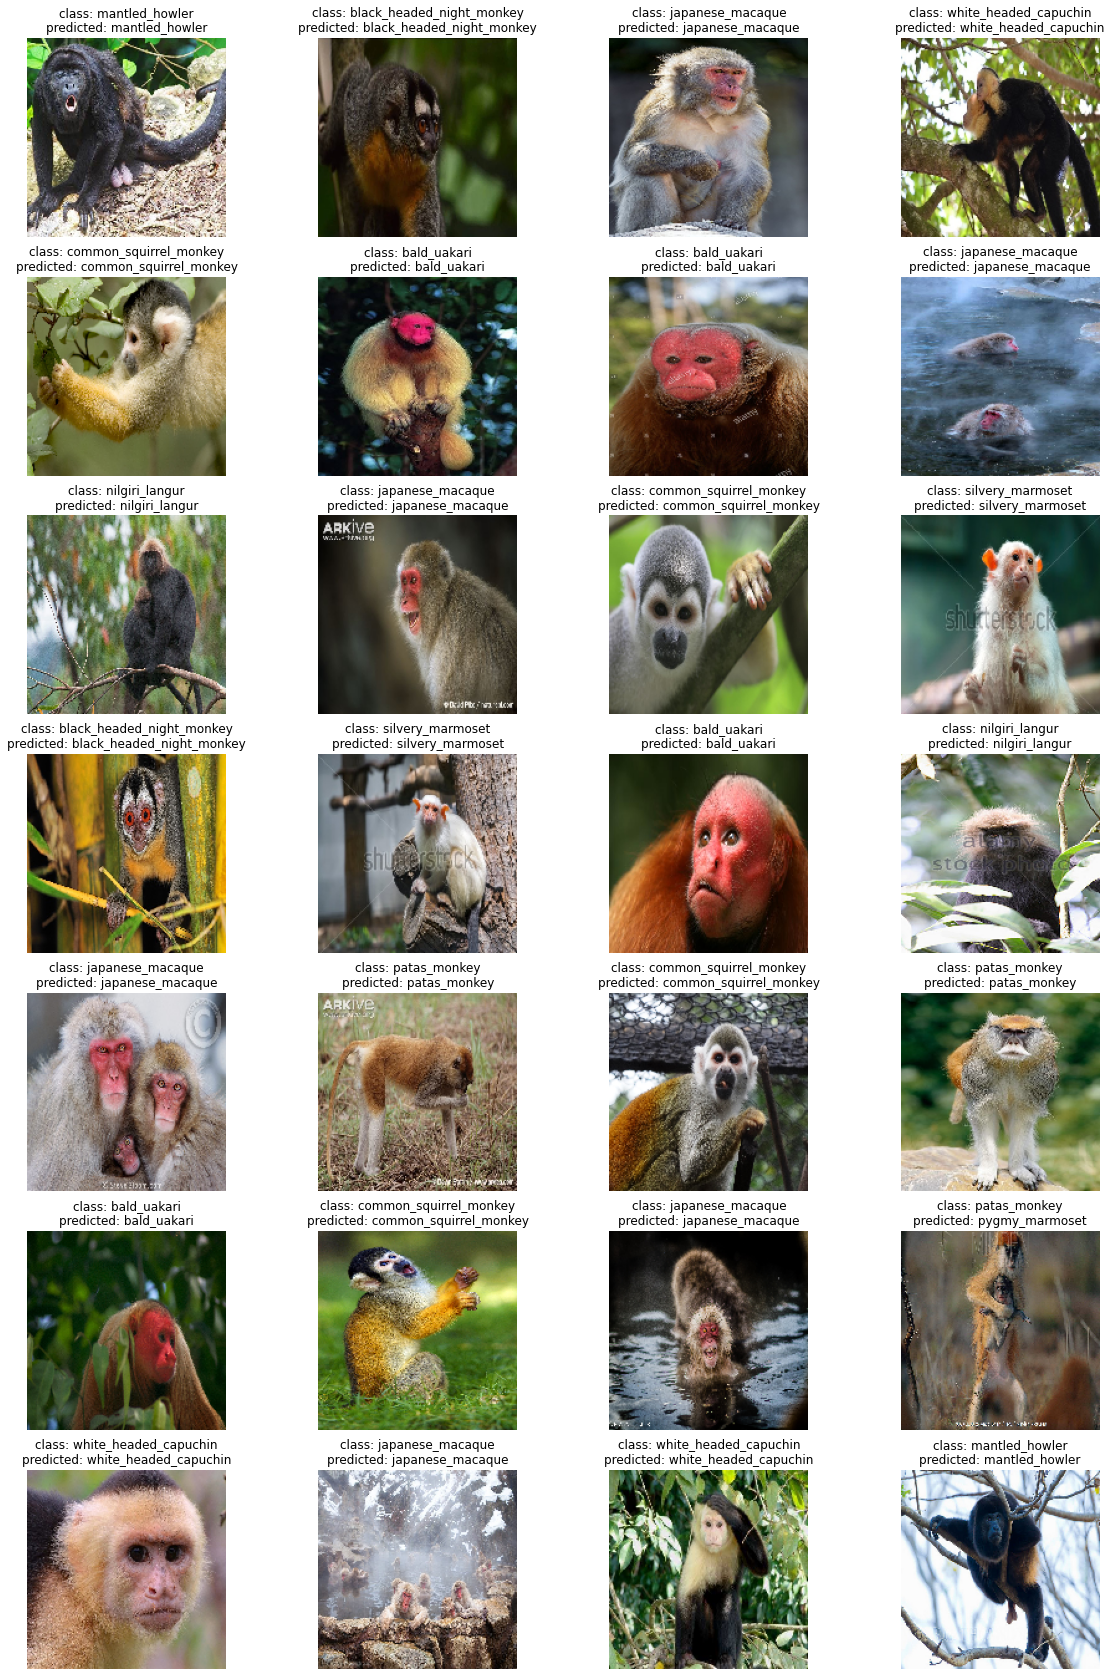

In [95]:
# prediction
plt.figure(figsize=(20, 30))
for i, idx in enumerate(random_indices):
    img = np.uint8(x[idx])
    plt.subplot(7, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("class: " + labels[classes[idx]] + "\npredicted: " + labels[predicted_classes[idx]])
plt.show()

In [96]:
print("Completed at ", datetime.now())

Completed at  2022-07-04 12:04:14.982538
